### Step 1: Data Loading & Preprocessing

In [2]:
# Import necessary libraries
import pandas as pd
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.impute import SimpleImputer
from sklearn.model_selection import ParameterGrid
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage

# Load the Excel file
file_path = 'E-commerce_data.xlsx'
data = pd.read_excel(file_path, sheet_name=None)

# Drop the 'burn_date' column from the 'transactions' sheet (if it exists)
if 'transactions' in data:
    transactions_df = data['transactions']
    if 'burn_date' in transactions_df.columns:
        transactions_df = transactions_df.drop(['burn_date'], axis=1)
    data['transactions'] = transactions_df  # Update the dictionary with the modified DataFrame

# Extract relevant data from the sheets
customers_df = data['customers']
transactions_df = data['transactions']
genders_df = data['genders']
cities_df = data['cities']

### Step 2: Data Merging

In [3]:
# Merge customers with genders and cities data
customers_df = pd.merge(customers_df, genders_df, how='left', on='gender_id')
customers_df = pd.merge(customers_df, cities_df, how='left', on='city_id')

### Step 3: Aggregating Transactions

In [4]:
# Calculate coupon usage frequency and total transactions from transactions data
coupon_usage = transactions_df.groupby('customer_id').size().reset_index(name='coupon_usage_frequency')
total_transactions = transactions_df.groupby('customer_id')['transaction_status'].count().reset_index(name='total_transactions')

# Merge coupon usage and transactions data with customers data
customer_transactions = pd.merge(customers_df, coupon_usage, how='left', on='customer_id')
customer_transactions = pd.merge(customer_transactions, total_transactions, how='left', on='customer_id')

### Step 4: Feature Selection, Imputation, and Scaling

In [5]:
# Select relevant features (after merging and calculating the required columns)
features = ['gender_name', 'city_name', 'coupon_usage_frequency', 'total_transactions']
X = customer_transactions[features]

# Separate categorical and numerical columns
categorical_cols = ['gender_name', 'city_name']
numerical_cols = ['coupon_usage_frequency', 'total_transactions']

# Handle missing data using SimpleImputer (different strategies for categorical and numerical columns)
categorical_imputer = SimpleImputer(strategy='most_frequent')
numerical_imputer = SimpleImputer(strategy='mean')  # Use 'mean' or 'median' for numerical columns

# Impute missing values separately
X_categorical_imputed = pd.DataFrame(categorical_imputer.fit_transform(X[categorical_cols]), columns=categorical_cols)
X_numerical_imputed = pd.DataFrame(numerical_imputer.fit_transform(X[numerical_cols]), columns=numerical_cols)

# Handle categorical variables (e.g., gender, city) - One Hot Encoding
X_categorical_imputed = pd.get_dummies(X_categorical_imputed, drop_first=True)

# Combine the imputed data
X_imputed = pd.concat([X_categorical_imputed, X_numerical_imputed], axis=1)

# Standardize the features (for Hierarchical clustering)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)  # for Hierarchical clustering
X_unscaled = X_imputed  # for K-Means and DBSCAN clustering

Scaling data decreases score for both K-Means and DBSCAN

### Step 5: K-Means Clustering - Tuning with Silhouette Scores

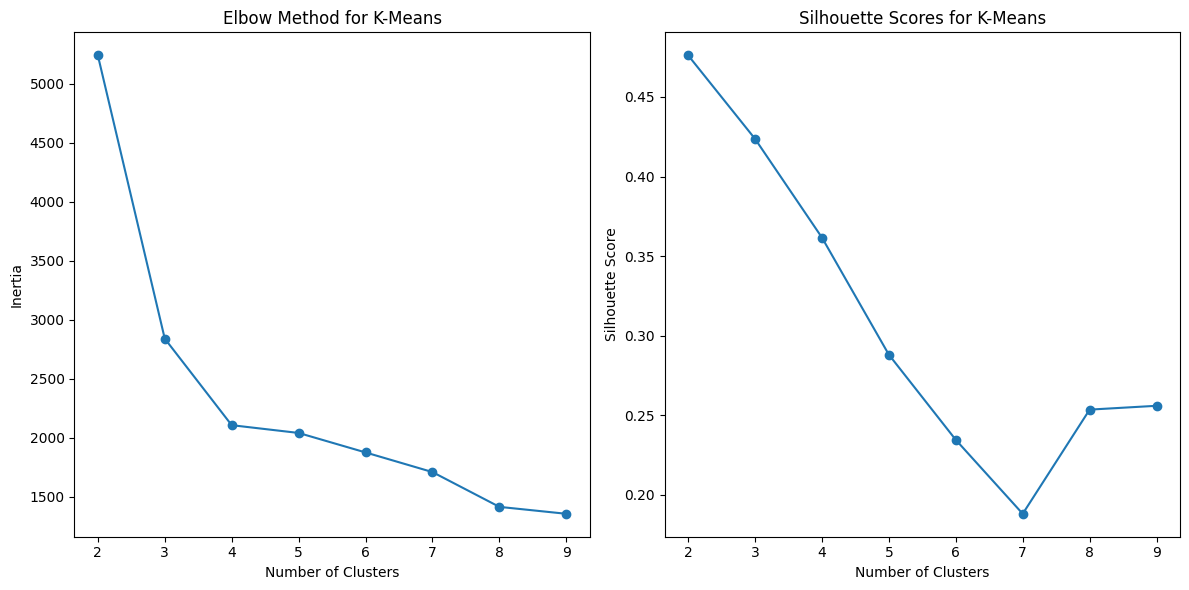

In [6]:
# Apply K-Means Clustering
inertia = []
silhouette_scores = []
range_n_clusters = range(2, 10)

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X_unscaled)
    cluster_labels = kmeans.predict(X_unscaled)
    
    # Inertia (sum of squared distances to closest cluster center)
    inertia.append(kmeans.inertia_)
    
    # Silhouette score
    silhouette_avg = silhouette_score(X_unscaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot Silhouette Score and Inertia to determine the optimal number of clusters
plt.figure(figsize=(12, 6))

# Plot Elbow Method for K-Means
plt.subplot(1, 2, 1)
plt.plot(range_n_clusters, inertia, marker='o')
plt.title('Elbow Method for K-Means')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')

# Plot Silhouette Scores for K-Means
plt.subplot(1, 2, 2)
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.title('Silhouette Scores for K-Means')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

# Best k based on silhouette score
best_k = range_n_clusters[silhouette_scores.index(max(silhouette_scores))]
kmeans_sil_score = max(silhouette_scores)

### Step 6: DBSCAN - Grid Search for Best Parameters

In [7]:
# Scale data for DBSCAN to potentially improve performance
X_dbscan_scaled = scaler.fit_transform(X_imputed)  # Scale data for DBSCAN

# Apply DBSCAN with a grid search over eps and min_samples
dbscan_params = {
    'eps': [0.3, 0.5, 0.7],
    'min_samples': [3, 5, 7]
}

best_sil_score_dbscan = -1
best_dbscan_params = None
for params in ParameterGrid(dbscan_params):
    dbscan = DBSCAN(eps=params['eps'], min_samples=params['min_samples'])
    dbscan_labels = dbscan.fit_predict(X_dbscan_scaled)
    
    # Avoid noise-only clusters by checking if clusters are formed
    core_samples_mask = (dbscan_labels != -1)  # Mask out the noise points
    if len(set(dbscan_labels[core_samples_mask])) > 1:
        sil_score_dbscan = silhouette_score(X_dbscan_scaled[core_samples_mask], dbscan_labels[core_samples_mask])
        if sil_score_dbscan > best_sil_score_dbscan:
            best_sil_score_dbscan = sil_score_dbscan
            best_dbscan_params = params

### Step 7: Hierarchical Clustering - Grid Search for Best Parameters

In [8]:
# Apply Hierarchical Clustering (AgglomerativeClustering)
hierarchical_params = {
    'n_clusters': [2, 3, 4, 5],
    'linkage': ['ward', 'complete', 'average', 'single']
}

best_sil_score_hierarchical = -1
best_hierarchical_params = None
for params in ParameterGrid(hierarchical_params):
    hierarchical = AgglomerativeClustering(n_clusters=params['n_clusters'], linkage=params['linkage'])
    hierarchical_labels = hierarchical.fit_predict(X_scaled)
    
    sil_score_hierarchical = silhouette_score(X_scaled, hierarchical_labels)
    if sil_score_hierarchical > best_sil_score_hierarchical:
        best_sil_score_hierarchical = sil_score_hierarchical
        best_hierarchical_params = params

# Create a comparison DataFrame
comparison_data = {
    'Model': ['K-Means', 'DBSCAN', 'Hierarchical'],
    'Best Params': [
        f'n_clusters={best_k}',
        f'eps={best_dbscan_params["eps"]}, min_samples={best_dbscan_params["min_samples"]}',
        f'n_clusters={best_hierarchical_params["n_clusters"]}, linkage={best_hierarchical_params["linkage"]}'
    ],
    'Silhouette Score': [
        kmeans_sil_score,
        best_sil_score_dbscan,
        best_sil_score_hierarchical
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df)


          Model                    Best Params  Silhouette Score
0       K-Means                   n_clusters=2          0.476190
1        DBSCAN         eps=0.3, min_samples=5          0.999160
2  Hierarchical  n_clusters=5, linkage=average          0.197888


### Step 8: PCA for Visualization

In [9]:
# Perform PCA to reduce data to 2D for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_imputed)  # Using unscaled data for visualization

### Step 9: Visualization

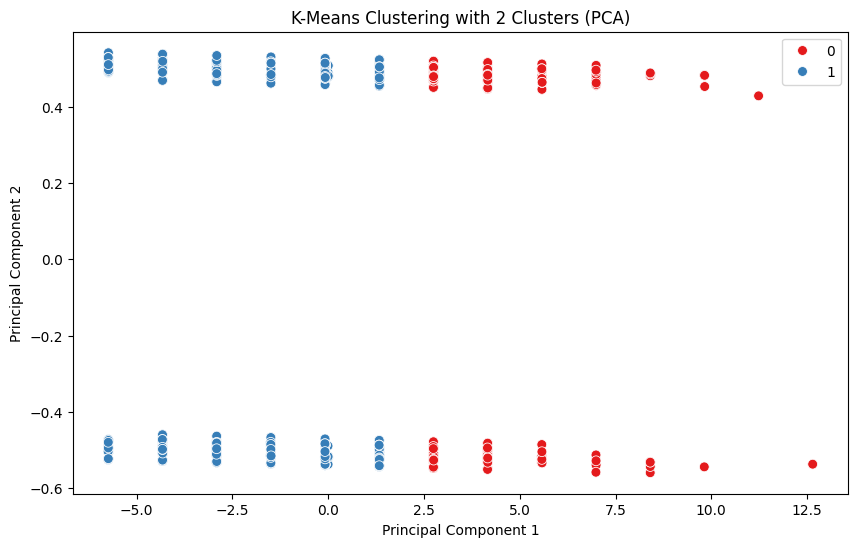

In [10]:
# Visualize K-Means clusters with best k
kmeans = KMeans(n_clusters=best_k, random_state=42)
kmeans_labels = kmeans.fit_predict(X_unscaled)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=kmeans_labels, palette='Set1', s=50)
plt.title(f'K-Means Clustering with {best_k} Clusters (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

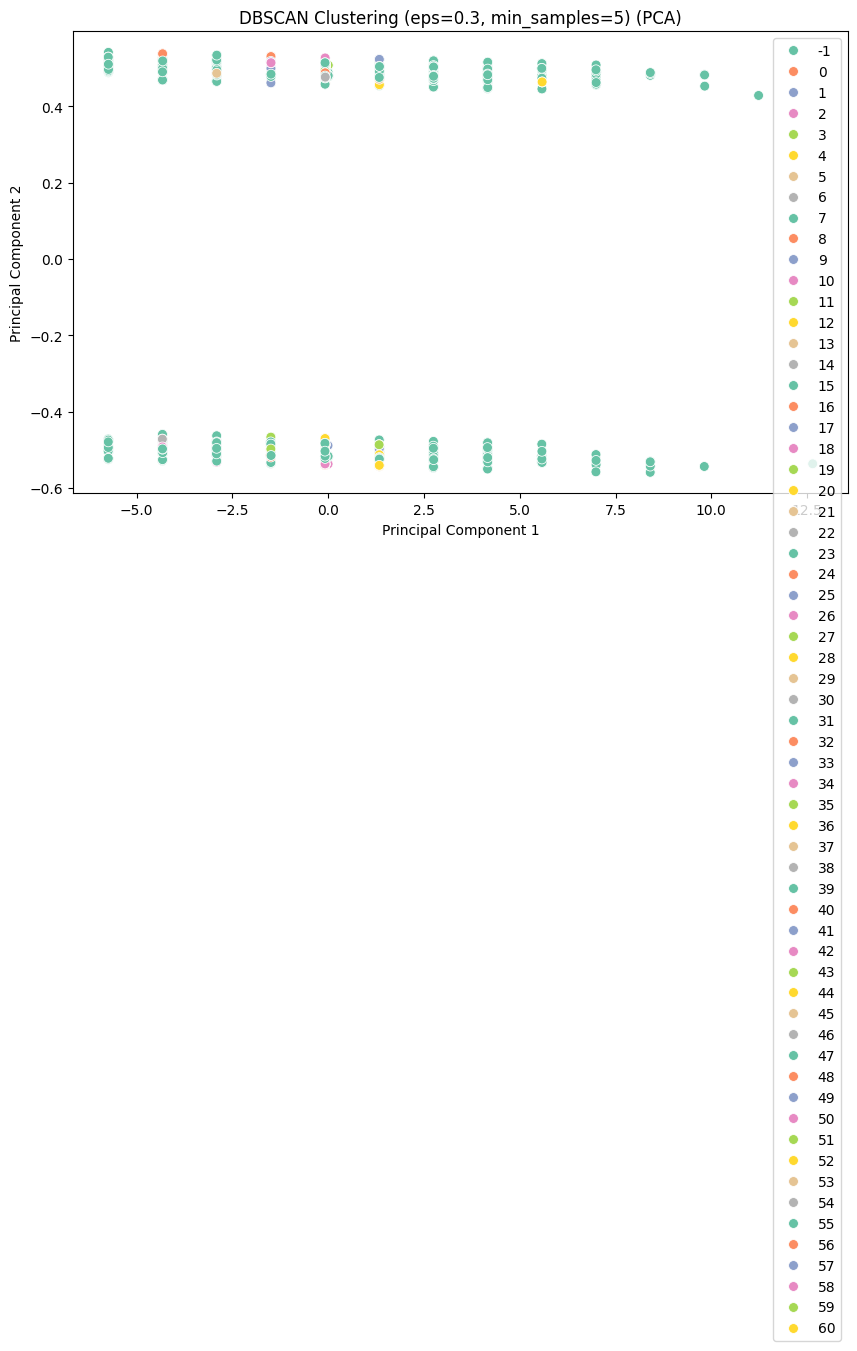

In [11]:
# Visualize DBSCAN clusters with best params
dbscan = DBSCAN(eps=best_dbscan_params['eps'], min_samples=best_dbscan_params['min_samples'])
dbscan_labels = dbscan.fit_predict(X_dbscan_scaled)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=dbscan_labels, palette='Set2', s=50)
plt.title(f'DBSCAN Clustering (eps={best_dbscan_params["eps"]}, min_samples={best_dbscan_params["min_samples"]}) (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

DBSCAN struggles with varying densities in the same dataset even though it got highest score. If clusters have very different densities, a single value for eps might not capture all clusters properly.
DBSCAN doesn't work well in high-dimensional spaces because the distance between points becomes less meaningful. In such cases, consider dimensionality reduction (e.g., PCA or t-SNE) before applying DBSCAN.

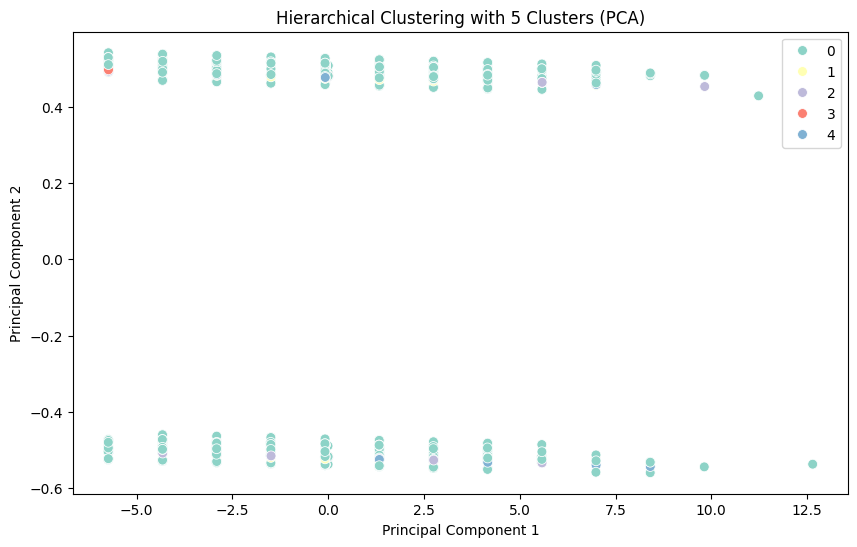

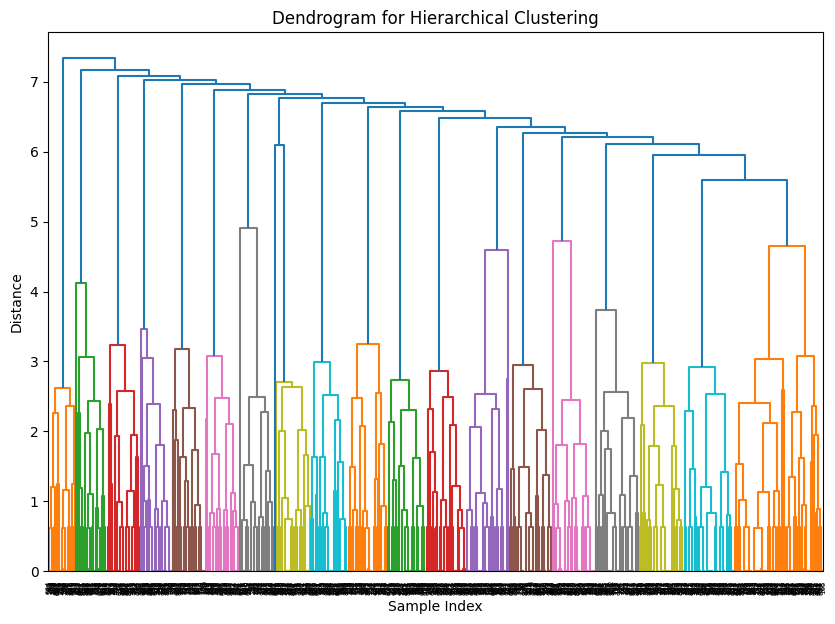

In [12]:
# Visualize Hierarchical Clustering with best params
hierarchical = AgglomerativeClustering(n_clusters=best_hierarchical_params['n_clusters'], linkage=best_hierarchical_params['linkage'])
hierarchical_labels = hierarchical.fit_predict(X_scaled)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=hierarchical_labels, palette='Set3', s=50)
plt.title(f'Hierarchical Clustering with {best_hierarchical_params["n_clusters"]} Clusters (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# Dendrogram for Hierarchical Clustering
Z = linkage(X_scaled, method=best_hierarchical_params['linkage'])
plt.figure(figsize=(10, 7))
dendrogram(Z)
plt.title('Dendrogram for Hierarchical Clustering')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()